本次作业代码全部采用numpy的array数组来进行计算，不采用矩阵  
两者在乘法和数量积的运算上采用的符号不同  
最好不要混用，开始之前先定下代码里用哪一种

# 神经网络 Neural Networks 

## 数据可视化 Visualizing the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat 

In [2]:
data = loadmat('ex4data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
data['X'].shape, data['y'].shape

((5000, 400), (5000, 1))

In [4]:
# 随机挑选100个图像
sample_idx = np.random.choice(np.arange(data['X'].shape[0]), 100)
sample_images = data['X'][sample_idx, :]
sample_images.shape

(100, 400)

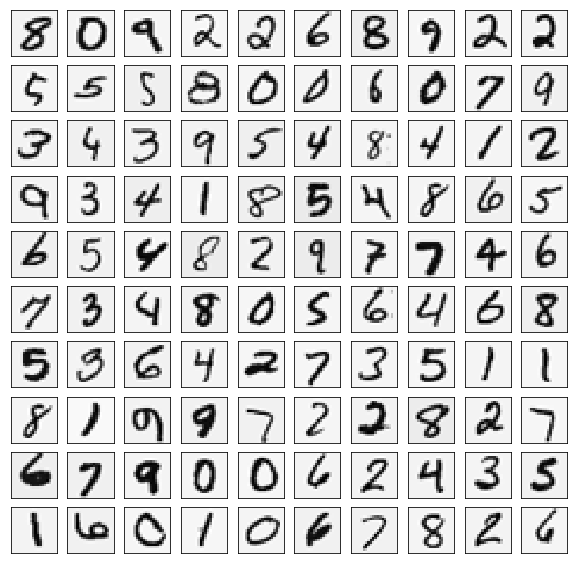

In [5]:
# 展示图像
fig, ax = plt.subplots(10, 10, sharey=True, sharex=True, figsize=(10, 10))
for r in range(10):
    for c in range(10):
        ax[r, c].matshow(np.array(sample_images[10 * r + c].reshape(20, 20)).T, cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([])) 

## 处理训练数据

### 标签重编码
首先我们要将标签值（1，2，3，4，…，10）转化成非线性相关的向量，向量对应位置（y[i-1]）上的值等于1，  
例如y[0]=6转化为y[0]=[0,0,0,0,0,1,0,0,0,0]。

In [6]:
def expend_y(y):
    result = []
    # 将y的每个元素转换为一个向量，标签值的位置为1，其余为0
    for label in y:
        y_array = np.zeros(10)
        y_array[label-1] = 1
        result.append(y_array)
    return np.array(result)

'''
也可以利用sklearn的编码函数

from sklearn.preprocessing import OneHotEncoder
    encoder = OneHotEncoder(sparse=False)
    y_onehot = encoder.fit_transform(y)
    y_onehot.shape 
'''

'\n也可以利用sklearn的编码函数\n\nfrom sklearn.preprocessing import OneHotEncoder\n    encoder = OneHotEncoder(sparse=False)\n    y_onehot = encoder.fit_transform(y)\n    y_onehot.shape \n'

验证y

In [7]:
y1 = np.arange(1, 11, 1).reshape((10, 1))
y1

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10]])

In [8]:
y2 = expend_y(y1)
y2.shape

(10, 10)

In [9]:
y2

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

### 获取训练数据集

In [10]:
X = np.insert(data['X'], 0, np.ones(len(data['X'])), axis=1)
raw_y = data['y']
y = expend_y(raw_y)

X.shape, y.shape

((5000, 401), (5000, 10))

读取已训练好的权重

In [11]:
weight = loadmat('ex4weights.mat')
weight

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Oct 18 14:57:02 2011',
 '__version__': '1.0',
 '__globals__': [],
 'Theta1': array([[-2.25623899e-02, -1.05624163e-08,  2.19414684e-09, ...,
         -1.30529929e-05, -5.04175101e-06,  2.80464449e-09],
        [-9.83811294e-02,  7.66168682e-09, -9.75873689e-09, ...,
         -5.60134007e-05,  2.00940969e-07,  3.54422854e-09],
        [ 1.16156052e-01, -8.77654466e-09,  8.16037764e-09, ...,
         -1.20951657e-04, -2.33669661e-06, -7.50668099e-09],
        ...,
        [-1.83220638e-01, -8.89272060e-09, -9.81968100e-09, ...,
          2.35311186e-05, -3.25484493e-06,  9.02499060e-09],
        [-7.02096331e-01,  3.05178374e-10,  2.56061008e-09, ...,
         -8.61759744e-04,  9.43449909e-05,  3.83761998e-09],
        [-3.50933229e-01,  8.85876862e-09, -6.57515140e-10, ...,
         -1.80365926e-06, -8.14464807e-06,  8.79454531e-09]]),
 'Theta2': array([[-0.76100352, -1.21244498, -0.10187131, -2.36850085, -1.057781

In [12]:
theta1 = weight['Theta1']
theta2 = weight['Theta2']

### 展开/合并参数
当我们使用高级优化方法来优化神经网络时，我们需要将多个参数矩阵展开，才能传入优化函数，然后再恢复形状。

In [13]:
def serialize(a, b):
    return np.concatenate((np.ravel(a), np.ravel(b)))

In [14]:
a = np.arange(10)
b = np.ones(5)
c = serialize(a, b)
c

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 1., 1., 1., 1., 1.])

In [15]:
def deserialize(seq):
    return seq[:25*401].reshape(25, 401), seq[25*401:].reshape(10, 26)

## 模型表示 Model representation
我们的网络有三层，输入层，隐藏层，输出层。我们的输入是数字图像的像素值，因为每个数字的图像大小为20*20，所以我们输入层有400个单元（这里不包括总是输出要加一个偏置单元）。
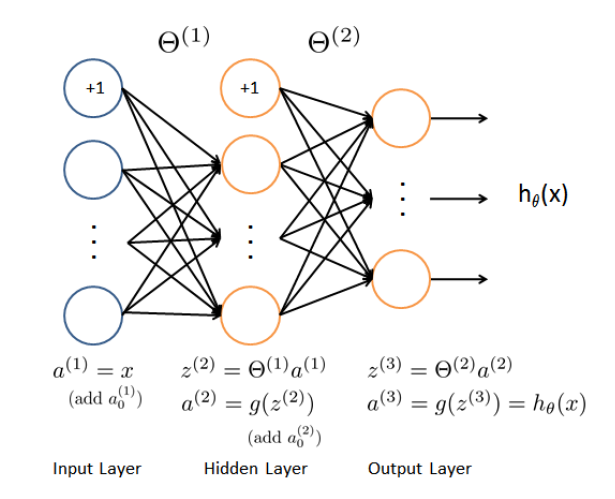

## 正向传播 Feedforward

In [16]:
# sigmoid函数
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [17]:
# 前向传播
def forward_propagation(theta, X): # theta,X都是array数组类型，非矩阵
    t1, t2 = deserialize(theta)
    
    a1 = X # 5000*401
    
    z2 = a1 @ t1.T # 5000*25
    a2 = sigmoid(z2)
    a2 = np.insert(a2, 0, np.ones(len(a2)), axis=1) # 5000*26
    
    z3 = a2 @ t2.T # 5000*10
    a3 = sigmoid(z3)
    h = a3  # 5000*10
    
    return a1, z2, a2, z3, h

In [18]:
theta = serialize(theta1, theta2)
a1, z2, a2, z3, h = forward_propagation(theta, X)

In [19]:
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((5000, 401), (5000, 25), (5000, 26), (5000, 10), (5000, 10))

In [20]:
forward_propagation(theta, X)[-1]

array([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
        4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
       [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
        2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
       [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
        6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
       ...,
       [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
        2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
       [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
        1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
       [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
        5.73434571e-03, 6.96288990e-01, 8.18576980e-02]])

## 代价函数 Cost function
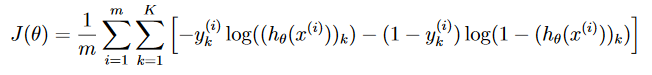

In [21]:
def nnCost(theta, X, y): # 均为数组
    h = forward_propagation(theta, X)[-1]
    temp = -y * np.log(h) - (1 - y) * np.log(1- h)
    return  temp.sum() / len(X)

In [22]:
nnCost(theta, X, y)

0.2876291651613189

## 正则化代价函数 regularized cost function
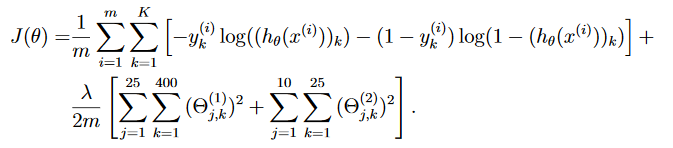

In [23]:
def nnCostReg(theta, X, y, lambdaRate):
    theta1, theta2 = deserialize(theta)
    
    first = nnCost(theta, X, y)
    
    reg1 = (np.power(theta1[:, 1: ], 2)).sum()
    reg2 = (np.power(theta2[:, 1: ], 2)).sum()
    reg = lambdaRate / (2 * len(X)) * (reg1 + reg2)
    
    return first + reg

In [24]:
nnCostReg(theta, X, y, lambdaRate=1)

0.38376985909092365

# 反向传播 Back propagation

## S函数梯度 Sigmoid gradient
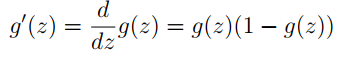

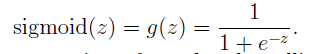

In [25]:
def sigmoid_gradient(z):
    return sigmoid(z) * (1- sigmoid(z))

In [26]:
sigmoid_gradient(0)

0.25

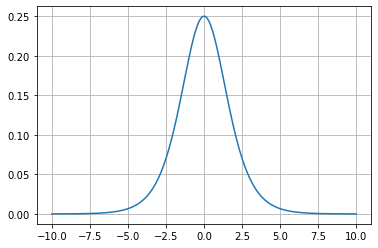

In [27]:
siggra_x = np.arange(-10, 10, 0.01)
plt.plot(siggra_x, sigmoid_gradient(siggra_x))
plt.grid()
plt.show()

由此可见，sigmoid的导数值最大为0.25，决定了其无法用于深层网络

## theta随机初始化 Random initialization
当我们训练神经网络时，随机初始化参数是很重要的，可以打破数据的对称性。  
一个有效的策略是在均匀分布(−e，e)中随机选择值，我们可以选择 e = 0.12 这个范围的值来确保参数足够小，使得训练更有效率。

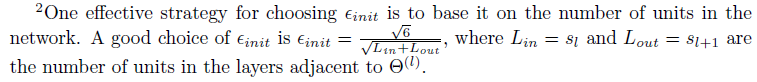

In [28]:
# 从服从均匀分布的范围中随机返回size大小的值
def random_init(size):
    return np.random.uniform(-0.12, 0.12, size)

In [29]:
random_init((3, 4))

array([[-0.03588089, -0.01860106,  0.0231179 ,  0.08834786],
       [-0.00270229, -0.04455686, -0.10708566,  0.09343351],
       [-0.04520061,  0.06483762, -0.08712267,  0.0488686 ]])

## 反向传播
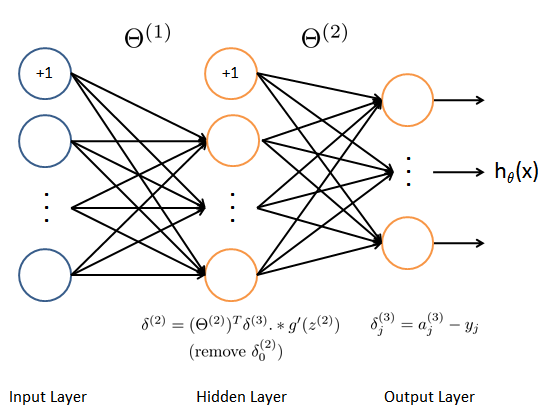

目标：获取整个网络代价函数的梯度，以便在优化算法中求解。  
步骤：给定训练集，先计算正向传播，再对于层的每个节点，计算误差项，这个数据衡量这个节点对最后输出  
的误差“贡献”了多少。  

这里面一定要理解正向传播和反向传播的过程，才能弄清楚各种参数在网络中的维度，切记。  
最好手写出每次传播的式子。

**公式**
1. 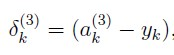
2. 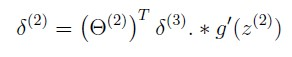
3. 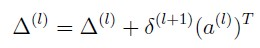
4. 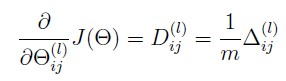

### 更新梯度

In [30]:
# 更新梯度
def nnGradient(theta, X, y):
    theta1, theta2 = deserialize(theta)
    # 首先正向传播
    a1, z2, a2, z3, h = forward_propagation(theta, X)
    # 针对每层的各个节点计算误差项
    d3 = h - y # 输出层误差 5000*10
    d2 = d3 @ theta2[:, 1:] * sigmoid_gradient(z2) # 隐藏层误差 5000*25
    
    delta1 = d2.T @ a1 # 25 * 401
    delta2 = d3.T @ a2 # 10 * 26
    delta = serialize(delta1, delta2) # (10285, )
    
    return delta / len(X) # (10285, )

In [31]:
d1, d2 = deserialize(nnGradient(theta, X, y))
d1.shape, d2.shape

((25, 401), (10, 26))

In [32]:
theta1.shape, theta2.shape

((25, 401), (10, 26))

## 梯度检验 Gradient checking
进行梯度校验时，需要把参数Θ(1)、Θ(2)连接成一个长向量。之后你可以使用如下公式计算:
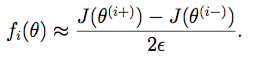

In [33]:
def gradient_checking(theta, X, y, eps, regularized=False):
    m = len(theta)
    
    def a_numeric_grad(plus, minus, X, y):
        if regularized:
            return (nnCostReg(plus, X, y) - nnCostReg(minus, X, y)) / (2 * eps)
        else:
            return (nnCost(plus, X, y) - nnCost(minus, X, y)) / (2 * eps)
        
    approxGrad = np.zeros(m)
    # 计算偏导数
    for i in range(m):  
        thetaPlus = theta.copy()
        thetaPlus[i] = theta[i] + eps
        
        thetaMinus = theta.copy()
        thetaMinus[i] = theta[i] - eps
        
        grad = a_numeric_grad(thetaPlus, thetaMinus, X, y)
        approxGrad[i] = grad
    
    # 用梯度公式
    funcGrad = nnGradientReg(theta, X, y) if  regularized else nnGradient(theta, X, y)
    
    diff = np.linalg.norm(approxGrad - funcGrad) / np.linalg.norm(approxGrad + funcGrad)
    
    print('If your backpropagation implementation is correct,\n'\
         + 'the relative difference will be smaller than 10e-9 (assume epsilon=0.0001).\n'
         + 'Relative Difference: {}\n'.format(diff))
    
    #return approxGrad.shape

In [34]:
# gradient_checking(theta, X, y, eps=0.0001, regularized=False) #这个运行很慢，谨慎运行

## 正则化神经网络 
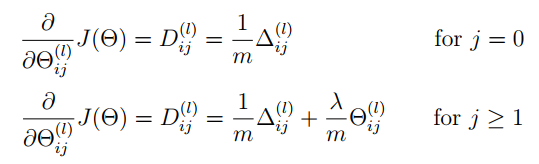

In [35]:
def nnGradientReg(theta, X, y, lambdaRate):
    first = nnGradient(theta, X, y)
    
    t1, t2 = deserialize(theta)
    t1[:, 0] = 0
    t2[:, 0] = 0
    
    reg = lambdaRate / len(X) * serialize(t1, t2)
    
    return first + reg

In [36]:
d1, d2 = deserialize(nnGradientReg(theta, X, y, lambdaRate=1))
d1.shape, d2.shape

((25, 401), (10, 26))

## 优化参数 Learning parameters using fmincg

In [37]:
from scipy import optimize as opt

def nnTraining(X, y):
    # 初始化theta
    init_theta = random_init(10285)
    
    res = opt.minimize(fun=nnCostReg,
                       x0=init_theta,
                       args=(X, y, 1),
                       method='TNC',
                       jac=nnGradientReg,
                       options={'maxiter':500})
    return res

In [38]:
res = nnTraining(X, y)
res

     fun: 0.33298285824302043
     jac: array([ 1.41541160e-04, -2.29401553e-07, -2.55382916e-07, ...,
       -5.01885346e-06, -3.60910199e-05, -2.47061167e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 21
  status: 3
 success: False
       x: array([ 0.00000000e+00, -1.14700777e-03, -1.27691458e-03, ...,
        1.63199029e+00, -2.96556538e+00, -1.95288757e+00])

## 性能评价

In [39]:
final_theta = res.x
final_theta.shape

(10285,)

In [40]:
h = forward_propagation(final_theta, X)[-1]
h.shape

(5000, 10)

In [41]:
y_predict = np.argmax(h, axis=1) + 1
y_predict = y_predict.reshape(5000, 1)

In [42]:
y_predict

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [10]], dtype=int64)

In [43]:
raw_y

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)

In [44]:
from sklearn.metrics import classification_report

print(classification_report(raw_y, y_predict))

              precision    recall  f1-score   support

           1       0.97      0.99      0.98       500
           2       0.98      0.98      0.98       500
           3       0.98      0.98      0.98       500
           4       1.00      0.95      0.97       500
           5       1.00      0.98      0.99       500
           6       0.98      0.99      0.99       500
           7       0.98      0.99      0.98       500
           8       0.98      0.99      0.99       500
           9       0.99      0.96      0.97       500
          10       0.96      1.00      0.98       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



# 可视化隐层 Visualizing the hidden layer
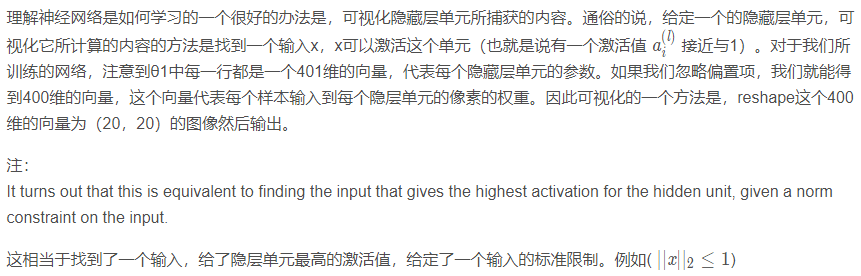
  
(这部分暂时不太理解)

In [45]:
theta1, theta2 = deserialize(final_theta)
hidden_layer = theta1[:, 1: ]
hidden_layer.shape

(25, 400)

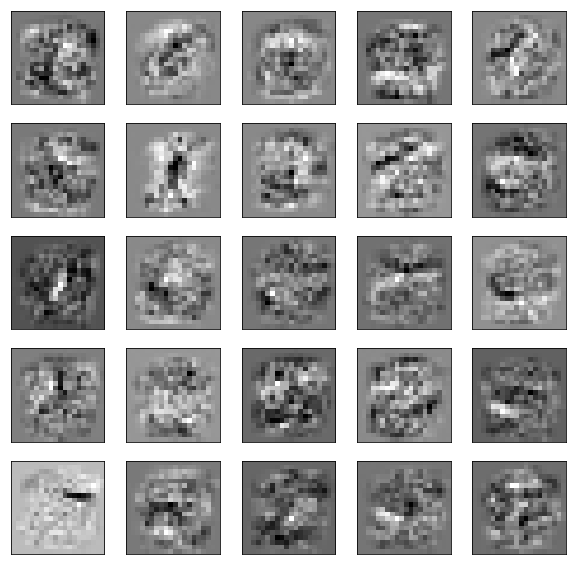

In [46]:
fig, ax = plt.subplots(5, 5, sharey=True, sharex=True, figsize=(10, 10))
for r in range(5):
    for c in range(5):
        ax[r, c].matshow(np.array(hidden_layer[5 * r + c].reshape(20, 20)).T, cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([])) 